In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geemap import ml
from sklearn import ensemble

import geemap, ee

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys  
sys.path.insert(0, '../lib/')
import sand_classification as sc
import quality_mosaic as qm
import train_val as tv

In [3]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

# Train a model using GEE's RF

## Fit the classifier

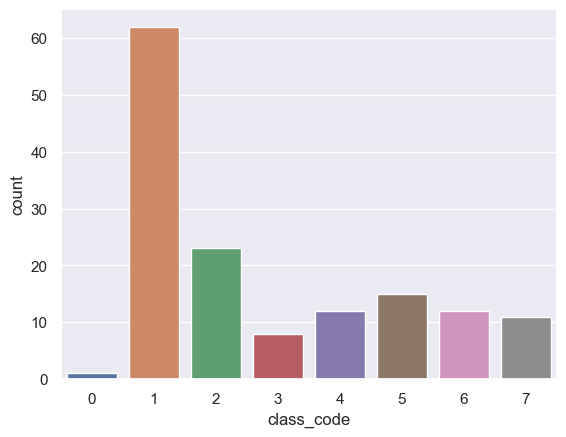

In [4]:
# RF, trees = train_classifier(labels, type='sklearn', n_estimators=400, max_depth=10) #,output_type='Prob')
RF, trees        = tv.train_rf('../data/labels/gt-bands.xlsx', rf_type='gee', num_trees=1000)


### Save RF Classifier to EE Asset

# Classify

In [14]:
# center for AOI
lon, lat = 84.2047028760486,24.90192702360151 #Dehri-on-Sone
# # lat, lon =  28.773532,  80.125429 #Sharda GST - DIngle 2016
# lat, lon =  29.102294,  80.142014 #Sharda-0
# # lat, lon = -23.856882,  35.548001 #Tofo
# lat, lon = -34.17182579028969, 24.641000758380677 #Oyster Bay
# lat, lon = 28.631691, 81.277637 #Karnali-4
lat, lon =  30.051389,  78.276702 #Ganga-0
lat, lon = 29.74481053, 78.19376654 #ganga-gst
roi_buffer_m = 5000

date = '2023-01-12'
max_search_window_months = 3
median_samples = 5
mosaic_method = 'median' #'qm'

In [15]:
point = ee.Geometry.Point([lon, lat])
roi = point.buffer(roi_buffer_m).bounds()


s1_s2 = qm.get_s1_s2(roi=roi, date=date, max_search_window_months=max_search_window_months,median_samples=median_samples, mosaic_method=mosaic_method, clip=False)
s1_s2.bandNames()

Search window from 2022-10-12 to 2023-04-12


In [16]:
Map = geemap.Map()
Map.centerObject(point, 14)
Map.add_basemap('SATELLITE')
Map.addLayer(s1_s2, qm.visParamsVV, 'S1', False)
Map.addLayer(s1_s2, qm.visParamsMTGSI , 'mTGSI')
Map.addLayer(s1_s2, qm.visParamsRGB, 'S2')
Map

Map(center=[29.74481053, 78.19376654], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…

In [9]:
snicBands = tv.apply_snic(image=s1_s2, roi=roi)

In [10]:
classy_RF = snicBands.classify(RF)
#necessary to keep the final resolution at 10m: not needed if you're zooming around and using interactively
# classy_RF = classy_RF.reproject (crs = classy_RF.projection (), scale = 10)

# classy_RF.getInfo()

Map.addLayer(
    classy_RF,
    {"min": 0, "max": len(qm.class_dict)-1, "palette": tv.palette},
    'classification',
)

Map.add_legend(title="Classes", legend_dict=tv.legend_dict, position="bottomleft")


# Map.add_legend(title="Classes", legend_dict=qm.legend_dict, position="bottomleft")


In [46]:
# palette_small = ['551a4d','f3ff4a','ffa500']
remapped_classy_RF_sand = classy_RF.remap([0,2,3,4,5,6,7], [0,2,3,4,5,6,7])
Map.addLayer(remapped_classy_RF_sand, {"palette": 'black'},
             '[mask]Sand');

In [43]:
RF_multi

In [26]:
RF_multi 
classy_RF_multi = snic.select(predictionBands).classify(RF_multi)
classy_RF_multi = classy_RF_multi.reproject (crs = classy_RF_multi.projection (), scale = 10)
# classy_RF_multi

classNameList = list(qm.legend_dict.keys())
rfresult_PROB = classy_RF_multi.arrayFlatten([classNameList])

remapped_classy_RF_multi = classy_RF_multi.remap([0,1,2,3,4,5,6,7], [0,1,2,0,0,0,0,0])

# Visualize only the sand layer (select numeric value corresponding with the class) 
# Map.addLayer(rfresult_PROB.select(['sand','gravel','water']), {'min':0, 'max':1},
#              'Tricolor')

# bgnd_color = '808080'

# Map.addLayer(rfresult_PROB.select(1), {'min':0, 'max':1, 'palette': [bgnd_color, 'ffff00']},
#              'RF membership for sand')
# Map.addLayer(rfresult_PROB.select(2), {'min':0, 'max':1, 'palette': [bgnd_color, 'ffa500']},
#              'RF membership for gravel')
# Map.addLayer(rfresult_PROB.select(7), {'min':0, 'max':1, 'palette': [bgnd_color, '551a4d']},
#              'RF membership for other')
# Map.addLayer(rfresult_PROB.select(4), {'min':0, 'max':1, 'palette': [bgnd_color, '2E86C1']},
#              'RF membership for water')

In [ ]:
classy_RF_multi = snic.select(predictionBands).classify(RF_multi)
classy_RF_multi = classy_RF_multi.reproject (crs = classy_RF_multi.projection (), scale = 10)
# classy_RF_multi

classNameList = list(qm.legend_dict.keys())
rfresult_PROB = classy_RF_multi.arrayFlatten([classNameList])

remapped_classy_RF_multi = classy_RF_multi.remap([0,1,2,3,4,5,6,7], [0,1,2,0,0,0,0,0])

# Visualize only the sand layer (select numeric value corresponding with the class) 
# Map.addLayer(rfresult_PROB.select(['sand','gravel','water']), {'min':0, 'max':1},
#              'Tricolor')

# bgnd_color = '808080'

# Map.addLayer(rfresult_PROB.select(1), {'min':0, 'max':1, 'palette': [bgnd_color, 'ffff00']},
#              'RF membership for sand')
# Map.addLayer(rfresult_PROB.select(2), {'min':0, 'max':1, 'palette': [bgnd_color, 'ffa500']},
#              'RF membership for gravel')
# Map.addLayer(rfresult_PROB.select(7), {'min':0, 'max':1, 'palette': [bgnd_color, '551a4d']},
#              'RF membership for other')
# Map.addLayer(rfresult_PROB.select(4), {'min':0, 'max':1, 'palette': [bgnd_color, '2E86C1']},
#              'RF membership for water')

In [38]:
def get_classifier_from_ee(modelname:str):
    ### Specify Asset ID
    asset_id = f"projects/gee-sand/assets/{modelname}"

    #### Load classifier
    rf_fc = ee.FeatureCollection(asset_id)

    # convert it to a classifier, very similar to the `ml.trees_to_classifier` function
    new_rf = ml.fc_to_classifier(rf_fc)
    
    return new_rf

RF_prob = get_classifier_from_ee('RFProb_gee_n400')
RF_prob

In [35]:
RF_multi

In [50]:
rfresult_PROB

In [47]:
Map.addLayer(rfresult_PROB.select(2), {'min':0, 'max':1},
             'RF membership for remapped other')

# Sand Mask Filter

Only pick pixels that have sand as the dominant pixel and it's overall prob is greater than a threshold

In [23]:
threshold = 0.5

In [29]:

sand_only = rfresult_PROB.select(1).gt(threshold)
Map.addLayer(sand_only, {'min':0, 'max':1, 'palette': ['000000', 'f3ff4a']},
             'sand only')


gravel_only = rfresult_PROB.select(2).gt(threshold)
Map.addLayer(gravel_only, {'min':0, 'max':1, 'palette': ['000000', 'ffa500']},
             'gravel only')




In [27]:
#select band 1 from remapped_classy_RF and add another band to it from rfresult_PROB.select(1)
sand_only = remapped_classy_RF.addBands(rfresult_PROB.select(1))
#now select only pixels where the first band is 1 (sand) and the second band is greater than 0.5
sand_only = sand_only.select(0).eq(1).And(sand_only.select(1).gt(0.5))
Map.addLayer(sand_only, {'min':0, 'max':1, 'palette': ['000000', 'f3ff4a']},
             'sand only2')
sand_only

NameError: name 'remapped_classy_RF' is not defined

## Save trees

In [30]:
# save_trees_gee(trees, 'RF_gee_n200')
save_trees_gee(trees, 'RF_gee_n400')
save_trees_gee(trees_multi, 'RFProb_gee_n400')

'projects/gee-sand/assets/RF_gee_n400'

'projects/gee-sand/assets/RFProb_gee_n400'